# Przegląd artykułów o modelach dyfuzji i generatywnym uczeniu maszynowym
---
### Z bloga *Towards Data Science*:
---

## 1. **[Graph Machine Learning with Python Pt. 2: Random Graphs and Diffusion Models of CryptoPunks Trading](https://towardsdatascience.com/graph-machine-learning-with-python-pt-2-random-graphs-and-diffusion-models-of-cryptopunks-trading-99cd5170b5ea/)** 
 
   Opisuje wykorzystanie modeli dyfuzji i grafów losowych do analizy handlu NFT (CryptoPunks). Pokazuje, jak modele te mogą przewidywać wzorce interakcji i rozprzestrzeniania się aktywności.
   
### Modele dyfuzji w sieciach

#### **Główne kategorie modeli dyfuzji***
1. Modele epidemiczne
2. Sieci opinii
3. Dynamiczne modele sieciowe

#### Model SI (Susceptible Infected)
- Dwa stany: podatny i zakażony
- Zakażone węzły zarażają sąsiadów z prawdopodobieństwem p
- Raz zakażony węzeł pozostaje zakażony na zawsze
- W eksperymencie: 25 węzłów początkowych wybranych według flow centrality, p=0.1
- Zbieżność po ok. 50 iteracjach

#### Model SIS (Susceptible Infected Susceptible)
- Zakażone węzły mogą wrócić do stanu podatności z prawdopodobieństwem s
- W eksperymencie: dodatkowo s=0.05
- Brak zbieżności w 200 iteracjach z powodu ponownych infekcji

#### Model SIR (Susceptible Infected Removed)
- Trzy stany: podatny, zakażony, usunięty
- Zakażone węzły zarażają sąsiadów z prawdop. p i są usuwane z prawdopodobieństwem r
- W eksperymencie: r=0.05
- Zbieżność po ok. 100 iteracjach

#### Model kaskady niezależnej (Independent Cascade)
- Każda krawędź ma własne prawdopodobieństwo transmisji
- Uogólniony model SIR
- W eksperymencie: próg T=0.3
- Szybka zbieżność po ok. 15 iteracjach

#### Model progu liniowego (Linear Threshold)
- Węzły mają próg podatności w przedziale [0,1]
- Krawędzie mają wagi określające siłę wpływu
- Węzeł przyjmuje zachowanie, gdy suma wag zakażonych sąsiadów przekroczy jego próg
- W eksperymencie: najszybsza zbieżność (ok. 10 iteracji)
- Model jest deterministyczny po ustaleniu wag, progów i węzłów początkowych

### 2. **[Diffusion Models Made Easy](https://towardsdatascience.com/diffusion-models-made-easy-8414298ce4da/)**  
   Przystępne wprowadzenie do podstaw modeli dyfuzji. Wyjaśnia jak modele uczą się "odszumiania" obrazów krok po kroku, zaczynając od szumu gaussowskiego.
  
#### Wprowadzenie
- Modele dyfuzyjne to alternatywa dla GANów i VAE w generatywnym uczeniu maszynowym
- Inspirowane zjawiskiem fizycznym dyfuzji gazów i zasadami termodynamiki
- Koncepcja: jeśli model może nauczyć się systematycznego zaniku informacji przez szum, to można odwrócić ten proces

#### Denoising Diffusion Model
- Dwuetapowy proces:
  1. Proces dyfuzji do przodu (forward diffusion)
  2. Proces rekonstrukcji/odwracania (reverse process)
- Ma korzenie w koncepcji Diffusion Maps i łańcuchach Markowa

#### Proces do przodu (Forward Process)
- Formalnie zdefiniowany jako łańcuch Markowa
- Nie wymaga trenowania, w przeciwieństwie do enkodera w VAE
- Polega na sukcesywnym dodawaniu szumu gaussowskiego do danych
- Prawdopodobieństwo w czasie t zależy tylko od stanu w czasie t-1
- Można próbkować stan w dowolnym punkcie czasu t bez przechodzenia przez wszystkie stany pośrednie
- Wykorzystuje koncepcję "dynamiki Langevina" z termodynamiki

#### Rekonstrukcja (Reverse Process)
- Wymaga estymacji gęstości prawdopodobieństwa wcześniejszego stanu na podstawie obecnego
- W przeciwieństwie do procesu do przodu, wymaga modelu uczenia się (sieci neuronowej)
- Sieć neuronowa estymuje ρθ(χτ-1|χτ) na podstawie wag θ i obecnego stanu
- Parametryzacja funkcji średniej zaproponowana przez Ho et al.

#### Trening i architektura modelu
- Architektura podobna do VAE, ale zwykle prostsza
- Warstwa wejściowa o wymiarach danych wejściowych
- Ukryte warstwy liniowe z funkcjami aktywacji
- Warstwa końcowa z dwoma oddzielnymi wyjściami dla średniej i wariancji


#### Funkcja straty
- Celem jest optymalizacja funkcji opartej na kombinacji liniowej dywergencji KL
- Uproszczona wersja zaproponowana przez Sohl-Dickstein et al.
- Dalsza optymalizacja wprowadzona przez Ho et al.

#### Zalety i zastosowania
- Mimo większej złożoności obliczeniowej, osiągają lepsze wyniki w niektórych zastosowaniach
- Sprawdzają się szczególnie w syntezie tekstu i obrazów

---

Generowanie danych syntetycznych...
Używanie zbioru danych o wymiarze: 2
Trenowanie modelu dyfuzyjnego...
Używanie urządzenia: cuda
Epoch 50/1000, Loss: 0.847795
Epoch 100/1000, Loss: 0.683070
Epoch 150/1000, Loss: 0.657856
Epoch 200/1000, Loss: 0.652416
Epoch 250/1000, Loss: 0.616306
Epoch 300/1000, Loss: 0.597551
Epoch 350/1000, Loss: 0.541779
Epoch 400/1000, Loss: 0.595455
Epoch 450/1000, Loss: 0.511715
Epoch 500/1000, Loss: 0.585223
Epoch 550/1000, Loss: 0.570957
Epoch 600/1000, Loss: 0.536408
Epoch 650/1000, Loss: 0.594575
Epoch 700/1000, Loss: 0.594962
Epoch 750/1000, Loss: 0.576129
Epoch 800/1000, Loss: 0.550833
Epoch 850/1000, Loss: 0.526004
Epoch 900/1000, Loss: 0.571799
Epoch 950/1000, Loss: 0.536286
Epoch 1000/1000, Loss: 0.554910


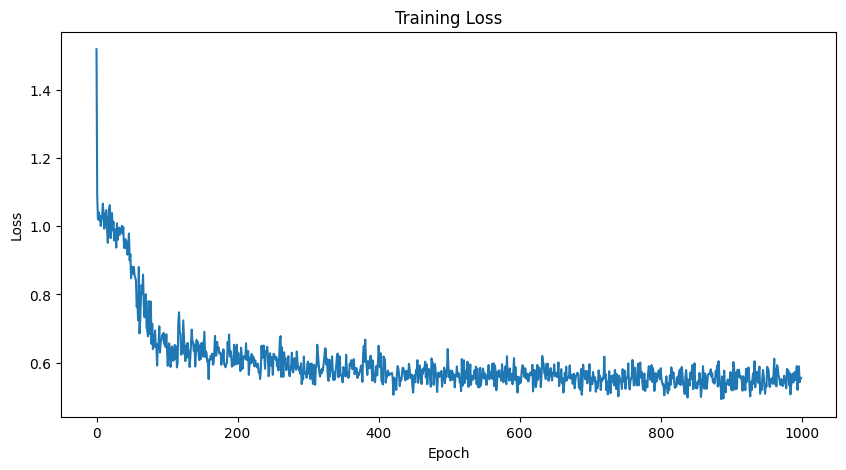

Wizualizacja procesu dyfuzji...


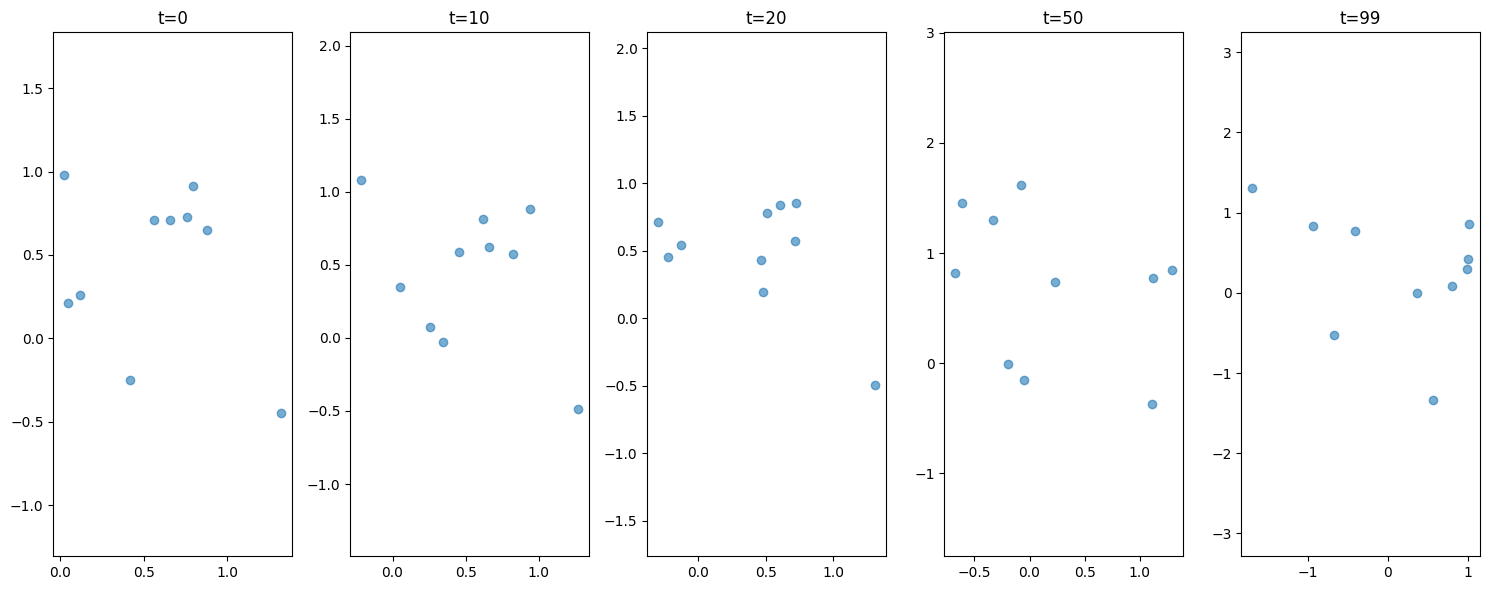

Generowanie nowych próbek...


Sampling: 100%|██████████| 100/100 [00:00<00:00, 476.99it/s]


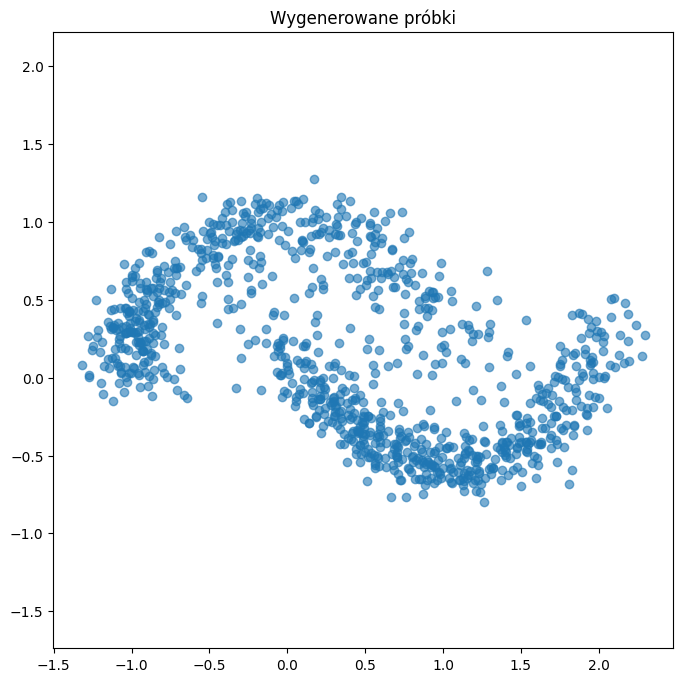

Gotowe!


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_s_curve, make_swiss_roll, make_moons
import tqdm

class DiffusionModel:
    def __init__(self, timesteps=100, beta_start=0.0001, beta_end=0.02, device=None):
        """
        Inicjalizacja modelu dyfuzyjnego.
        
        Args:
            timesteps: Liczba kroków dyfuzji
            beta_start: Początkowa wartość beta dla procesu dyfuzji
            beta_end: Końcowa wartość beta dla procesu dyfuzji
            device: Urządzenie, na którym będą wykonywane obliczenia
        """
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.timesteps = timesteps
        
        # Parametry procesu dyfuzji - wszystkie na odpowiednim urządzeniu
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(self.device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        
        # Dla obliczania x_0 bezpośrednio z x_t i przewidywanego szumu
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)
        
        # Dla obliczania parametrów dla q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1. - self.alphas_cumprod_prev) / (1. - self.alphas_cumprod)
    
    def forward_process(self, x_0, t):
        """
        Proces dyfuzji do przodu - dodaje szum do x_0 w czasie t.
        
        Args:
            x_0: Początkowe próbki (czyste dane)
            t: Krok czasowy
        
        Returns:
            Zaszumione dane x_t i szum
        """
        # Upewnij się, że t jest na tym samym urządzeniu co x_0
        t = t.to(x_0.device)
        
        noise = torch.randn_like(x_0)
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].to(x_0.device).reshape(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].to(x_0.device).reshape(-1, 1)
        
        # Wzór z artykułu: x_t = sqrt(alphas_cumprod) * x_0 + sqrt(1-alphas_cumprod) * noise
        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t, noise
    
    def sample_timesteps(self, n):
        """Losuje kroki czasowe dla partii próbek."""
        return torch.randint(0, self.timesteps, (n,)).to(self.device)
    
    @torch.no_grad()
    def sample(self, model, n_samples, dim):
        """
        Proces rekonstrukcji - generuje próbki zaczynając od czystego szumu.
        
        Args:
            model: Model uczenia maszynowego przewidujący szum
            n_samples: Liczba próbek do wygenerowania
            dim: Wymiar danych
        
        Returns:
            Wygenerowane próbki
        """
        device = next(model.parameters()).device
        
        # Start od czystego szumu
        x = torch.randn((n_samples, dim), device=device)
        
        # Iteracyjna denoizacja
        for t in tqdm.tqdm(reversed(range(self.timesteps)), desc="Sampling", total=self.timesteps):
            t_tensor = torch.tensor([t] * n_samples, device=device)
            
            # Przewidywanie szumu
            predicted_noise = model(x, t_tensor)
            
            # Obliczanie parametrów rozkładu - upewnij się, że są na właściwym urządzeniu
            alpha = self.alphas[t].to(device)
            alpha_cumprod = self.alphas_cumprod[t].to(device)
            beta = self.betas[t].to(device)
            
            # Tylko dla ostatniego kroku używamy deterministycznej próbki
            if t > 0:
                noise = torch.randn_like(x)
            else:
                noise = torch.zeros_like(x)
                
            # Wzór dla odwrotnego procesu
            x = 1 / torch.sqrt(alpha) * (
                x - beta / torch.sqrt(1 - alpha_cumprod) * predicted_noise
            ) + torch.sqrt(beta) * noise
        
        return x


class DiffusionNetwork(nn.Module):
    """Sieć neuronowa do modelowania procesu dyfuzji."""
    
    def __init__(self, input_dim, hidden_dim=128):
        """
        Args:
            input_dim: Wymiar danych wejściowych
            hidden_dim: Wymiar warstw ukrytych
        """
        super().__init__()
        
        # Warstwy sieci
        self.time_embedding = nn.Linear(1, hidden_dim)
        
        self.net = nn.Sequential(
            nn.Linear(input_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, x, t):
        """
        Forward pass.
        
        Args:
            x: Dane wejściowe [batch_size, input_dim]
            t: Kroki czasowe [batch_size]
        
        Returns:
            Przewidywany szum
        """
        # Upewnij się, że t ma odpowiedni kształt i typ
        t = t.to(x.device)
        
        # Osadzenie czasu jako wektor
        t_embed = self.time_embedding(t.unsqueeze(-1).float())
        
        # Konkatenacja danych i osadzenia czasu
        x_embed = torch.cat((x, t_embed), dim=-1)
        
        # Przewidywany szum
        predicted_noise = self.net(x_embed)
        
        return predicted_noise


def train_diffusion_model(data, input_dim, epochs=500, batch_size=128, lr=1e-3):
    """
    Trenuje model dyfuzyjny na podanych danych.
    
    Args:
        data: Dane treningowe
        input_dim: Wymiar danych wejściowych
        epochs: Liczba epok
        batch_size: Rozmiar partii
        lr: Współczynnik uczenia
    
    Returns:
        Wytrenowany model i historię straty
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Używanie urządzenia: {device}")
    
    # Inicjalizacja modelu dyfuzyjnego i sieci
    diffusion = DiffusionModel(device=device)
    model = DiffusionNetwork(input_dim).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Przygotowanie danych
    data_tensor = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    
    # Pętla treningowa
    for epoch in range(epochs):
        epoch_loss = 0.0
        
        for batch in loader:
            x_0 = batch[0].to(device)
            batch_size = x_0.shape[0]
            
            # Losowy krok czasowy dla każdej próbki
            t = diffusion.sample_timesteps(batch_size)
            
            # Proces dyfuzji do przodu
            x_t, noise = diffusion.forward_process(x_0, t)
            
            # Przewidywanie szumu
            predicted_noise = model(x_t, t)
            
            # Funkcja straty MSE
            loss = F.mse_loss(predicted_noise, noise)
            
            # Aktualizacja wag
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(loader)
        losses.append(avg_loss)
        
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")
    
    return model, losses, diffusion


def generate_and_visualize(diffusion, model, n_samples, dim, title):
    """
    Generuje i wizualizuje próbki z modelu dyfuzyjnego.
    
    Args:
        diffusion: Model dyfuzyjny
        model: Wytrenowana sieć neuronowa
        n_samples: Liczba próbek do wygenerowania
        dim: Wymiar danych
        title: Tytuł wykresu
    """
    samples = diffusion.sample(model, n_samples, dim).cpu().numpy()
    
    if dim == 2:
        plt.figure(figsize=(8, 8))
        plt.scatter(samples[:, 0], samples[:, 1], alpha=0.6)
        plt.title(title)
        plt.axis('equal')
        plt.show()
    elif dim == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.6)
        ax.set_title(title)
        plt.show()


def visualize_diffusion_process(diffusion, data, timesteps):
    """
    Wizualizuje proces dyfuzji do przodu na wybranych krokach czasowych.
    
    Args:
        diffusion: Model dyfuzyjny
        data: Dane wejściowe
        timesteps: Lista kroków czasowych do wizualizacji
    """
    device = diffusion.device
    data_tensor = torch.tensor(data, dtype=torch.float32).to(device)
    
    plt.figure(figsize=(15, 6))
    for i, t in enumerate(timesteps):
        t_tensor = torch.tensor([t] * len(data_tensor), device=device)
        noisy_data, _ = diffusion.forward_process(data_tensor, t_tensor)
        noisy_data = noisy_data.cpu().numpy()
        
        plt.subplot(1, len(timesteps), i+1)
        if noisy_data.shape[1] == 2:
            plt.scatter(noisy_data[:, 0], noisy_data[:, 1], alpha=0.6)
        else:
            plt.scatter(noisy_data[:, 0], noisy_data[:, 1], c=noisy_data[:, 2], cmap='viridis')
        plt.title(f"t={t}")
        plt.axis('equal')
    
    plt.tight_layout()
    plt.show()


# Przykład użycia
if __name__ == "__main__":
    # Generowanie danych syntetycznych
    n_samples = 1000
    
    # Wybierz jeden z dostępnych zbiorów danych
    print("Generowanie danych syntetycznych...")
    
    # Opcja 1: Zbiór danych S-curve (3D)
    # s_curve_data, _ = make_s_curve(n_samples, noise=0.1)
    # s_curve_data = s_curve_data / 5.0  # Normalizacja
    # input_dim = 3
    # data = s_curve_data
    
    # Opcja 2: Zbiór danych Swiss Roll (3D)
    # swiss_roll_data, _ = make_swiss_roll(n_samples, noise=0.1)
    # swiss_roll_data = swiss_roll_data / 15.0  # Normalizacja
    # input_dim = 3
    # data = swiss_roll_data
    
    # Opcja 3: Zbiór danych Moon (2D)
    moon_data, _ = make_moons(n_samples, noise=0.1)
    input_dim = 2
    data = moon_data
    
    print(f"Używanie zbioru danych o wymiarze: {input_dim}")
    
    # Trenowanie modelu
    print("Trenowanie modelu dyfuzyjnego...")
    model, losses, diffusion = train_diffusion_model(data, input_dim, epochs=1000)
    
    # Wizualizacja straty
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
    # Wizualizacja procesu dyfuzji do przodu
    print("Wizualizacja procesu dyfuzji...")
    sample_indices = np.random.choice(len(data), 10, replace=False)
    sample_data = data[sample_indices]
    timesteps = [0, 10, 20, 50, 99]  # Wybrane kroki czasowe
    visualize_diffusion_process(diffusion, sample_data, timesteps)
    
    # Generowanie nowych próbek
    print("Generowanie nowych próbek...")
    generate_and_visualize(diffusion, model, 1000, input_dim, "Wygenerowane próbki")
    
    print("Gotowe!")

3. **[Image Generation with Diffusion Models using Keras and TensorFlow](https://towardsdatascience.com/image-generation-with-diffusion-models-using-keras-and-tensorflow-9f60aae72ac/)**  

   Pokazuje praktyczną implementację modelu dyfuzji w Keras i TensorFlow, krok po kroku, od przygotowania danych do generacji obrazów.

---

4. **[What Are Stable Diffusion Models and Why Are They a Step Forward for Image Generation?](https://towardsdatascience.com/what-are-stable-diffusion-models-and-why-are-they-a-step-forward-for-image-generation-aa1182801d46/)**  
   Opisuje Stable Diffusion – modele, które działają efektywnie na ograniczonych zasobach sprzętowych i mogą generować obrazy wysokiej jakości z tekstu.

---

5. **[Comparing and Explaining Diffusion Models in HuggingFace Diffusers](https://towardsdatascience.com/comparing-and-explaining-diffusion-models-in-huggingface-diffusers-a83d64348d90/)**  
   Porównanie popularnych modeli dyfuzji (DDPM, DDIM, Latent Diffusion) w bibliotece HuggingFace Diffusers. Omawia ich zalety i różnice.
---

6. **[The Rise of Diffusion Models: A New Era of Generative Deep Learning](https://towardsdatascience.com/the-rise-of-diffusion-models-a-new-era-of-generative-deep-learning-3ef4779f6e1b-2/)**  
   Szerokie spojrzenie na rozwój modeli dyfuzji, ich miejsce w historii uczenia głębokiego oraz ich przewagę nad GAN-ami w wielu zastosowaniach.
---

7. **[Let There Be Light: Diffusion Models and the Future of Relighting](https://towardsdatascience.com/let-there-be-light-diffusion-models-and-the-future-of-relighting-03af12b8e86c/)**  
   Zastosowanie modeli dyfuzji do zadania "relightingu" – generowania różnych wariantów oświetlenia scen na podstawie jednego obrazu.
   
---

8. **[A Visual Guide to How Diffusion Models Work](https://towardsdatascience.com/a-visual-guide-to-how-diffusion-models-work/)**  
   Wizualne, intuicyjne wyjaśnienie działania modeli dyfuzji. 
---

### Z arXiv:

9. **[DDPM – Denoising Diffusion Probabilistic Models (Ho et al., 2020)](https://arxiv.org/pdf/2006.11239)**  
   Artykuł wprowadzający DDPM – probabilistyczne modele dyfuzji. Fundament teoretyczny dla wielu nowszych podejść.
---

10. **[Score-Based Generative Modeling through Stochastic Differential Equations (Song et al., 2021)](https://arxiv.org/pdf/2105.05233)**  
   Nowatorskie podejście do generowania danych przy użyciu równań różniczkowych stochastycznych (SDE), będące alternatywą dla klasycznych DDPM.
---

11. **[Elucidating the Design Space of Diffusion-Based Generative Models (Karras et al., 2022)](https://arxiv.org/pdf/2211.09526)**  
   Zaawansowana analiza różnych wariantów modeli dyfuzji. Autorzy (m.in. Karras od StyleGAN) badają wpływ architektury, harmonogramów szumu i więcej.

---